In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import phoenixAES

In [2]:
SIMFILE = 'sim.log'
refkey = None
refinp = None
refout = None
data = []
with open(SIMFILE, 'r') as f:
    buf = None
    for ctr, line in enumerate(f.readlines()):
        line = line.strip()
        if not refkey and 'keybuf' in line:
            refkey = line.split(': ')[1][:32]
            print(f'refkey: {refkey}')
        elif not refinp and 'inpbuf' in line:
            refinp = line.split(': ')[1][:32]
            print(f'refinp: {refinp}')
        elif not refout and 'outbuf' in line: # assume correct output is among the first lines
            refout = line.split(': ')[1][:32]
            print(f'refout: {refout}')
        elif refinp and refkey and ('keybuf' in line or 'inpbuf' in line):
            pass
        elif 'fi_target_ins' in line:
            if buf:
                data.append(buf)
            buf = {}
            buf['fi_target_ins'] = int(line.split(': ')[1])
            buf['exception'] = None
            buf['outbuf'] = None
        elif buf and 'Exception' in line:
            if buf['exception']:
                print(f'buf already has exception: {buf}')
            buf['exception'] = line
        elif buf and 'outbuf' in line:
            if buf['outbuf']:
                print(f'buf already has outbuf: {buf}')
            buf['outbuf'] = line.split(': ')[1][:32]
        else:
            print(f'unknown line: {line}')
print(data[:10])

refkey: df92119f723cb00a121f232e0cfa7d26
refinp: a0d5d5810e4157aa2af5af5d92ca3e0f
refout: 0196ec73825b49a36d5a8a05f5c9a660
unknown line: outbuf: 0196ec73825b49a36d5a8a05f5c9a660 (1)
[{'fi_target_ins': 1976, 'exception': None, 'outbuf': 'e759c74920c6e8cc48a418b356ef0561'}, {'fi_target_ins': 1977, 'exception': "Exception: <class 'unicorn.unicorn.UcError'> Invalid memory mapping (UC_ERR_MAP)", 'outbuf': None}, {'fi_target_ins': 1978, 'exception': None, 'outbuf': 'a0d5d5810e4157aa2af5af5d92ca3e0f'}, {'fi_target_ins': 1979, 'exception': None, 'outbuf': 'd839856928d9722a7a43fcd04cc5b433'}, {'fi_target_ins': 1980, 'exception': None, 'outbuf': 'a0d5d5810e4157aa2af5af5d92ca3e0f'}, {'fi_target_ins': 1981, 'exception': "Exception: <class 'unicorn.unicorn.UcError'> Invalid memory mapping (UC_ERR_MAP)", 'outbuf': None}, {'fi_target_ins': 1982, 'exception': "Exception: <class 'unicorn.unicorn.UcError'> Invalid memory read (UC_ERR_READ_UNMAPPED)", 'outbuf': None}, {'fi_target_ins': 1983, 'exception':

In [3]:
df = pd.DataFrame(data)
df

,fi_target_ins,exception,outbuf
0,1976,None,e759c74920c6e8cc48a418b356ef0561
1,1977,Exception: <class 'unicorn.unicorn.UcError'> I...,None
2,1978,None,a0d5d5810e4157aa2af5af5d92ca3e0f
3,1979,None,d839856928d9722a7a43fcd04cc5b433
4,1980,None,a0d5d5810e4157aa2af5af5d92ca3e0f
...,...,...,...
4717,6693,None,0196ec73825b49a36d5a8a05f5c9a660
4718,6694,None,0196ec73825b49a36d5a8a05f5c9a660
4719,6695,None,0196ec73825b49a36d5a8a05f5c9a660
4720,6696,None,0196ec73825b49a36d5a8a05f5c9a660


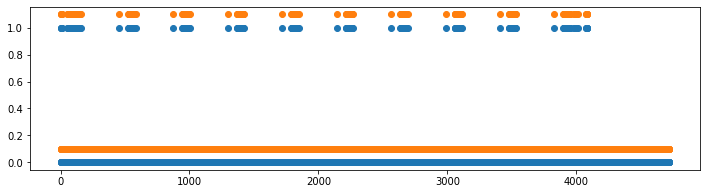

In [4]:
fig, ax = plt.subplots(1,1, figsize=(6*2,3))

ax.scatter(range(len(df['outbuf'])), df['outbuf'].isnull())
ax.scatter(range(len(df['outbuf'])), df['exception'].notnull()+.1)


In [104]:
ret = phoenixAES.check(bytes.fromhex(refout), encrypt=True, verbose=0, init=True)
        
def assign_category(row: pd.core.series.Series):
    if row['exception'] != None:
        exception_type = row['exception'].split('(')[1].split(')')[0]
        return exception_type #'exception'
    if row['outbuf'] == None:
        return 'no_outbuf'
    if row['outbuf'] == refout:
        return 'no_effect'

    ret = phoenixAES.check(bytes.fromhex(row['outbuf']), encrypt=True, verbose=0, init=False)
    return str(ret[0])

df['category'] = df.apply(assign_category, axis=1)
df


,fi_target_ins,exception,outbuf,category,category_num
0,1976,None,e759c74920c6e8cc48a418b356ef0561,FaultStatus.MajorFault,0
1,1977,Exception: <class 'unicorn.unicorn.UcError'> I...,None,UC_ERR_MAP,1
2,1978,None,a0d5d5810e4157aa2af5af5d92ca3e0f,FaultStatus.MajorFault,0
3,1979,None,d839856928d9722a7a43fcd04cc5b433,FaultStatus.MajorFault,0
4,1980,None,a0d5d5810e4157aa2af5af5d92ca3e0f,FaultStatus.MajorFault,0
...,...,...,...,...,...
4717,6693,None,0196ec73825b49a36d5a8a05f5c9a660,no_effect,2
4718,6694,None,0196ec73825b49a36d5a8a05f5c9a660,no_effect,2
4719,6695,None,0196ec73825b49a36d5a8a05f5c9a660,no_effect,2
4720,6696,None,0196ec73825b49a36d5a8a05f5c9a660,no_effect,2


In [105]:
category_mapping = dict(zip(df['category'].unique(), range(len(df['category'].unique()))))
df['category_num'] = df['category'].apply(lambda x: category_mapping[x])
df

,fi_target_ins,exception,outbuf,category,category_num
0,1976,None,e759c74920c6e8cc48a418b356ef0561,FaultStatus.MajorFault,0
1,1977,Exception: <class 'unicorn.unicorn.UcError'> I...,None,UC_ERR_MAP,1
2,1978,None,a0d5d5810e4157aa2af5af5d92ca3e0f,FaultStatus.MajorFault,0
3,1979,None,d839856928d9722a7a43fcd04cc5b433,FaultStatus.MajorFault,0
4,1980,None,a0d5d5810e4157aa2af5af5d92ca3e0f,FaultStatus.MajorFault,0
...,...,...,...,...,...
4717,6693,None,0196ec73825b49a36d5a8a05f5c9a660,no_effect,3
4718,6694,None,0196ec73825b49a36d5a8a05f5c9a660,no_effect,3
4719,6695,None,0196ec73825b49a36d5a8a05f5c9a660,no_effect,3
4720,6696,None,0196ec73825b49a36d5a8a05f5c9a660,no_effect,3


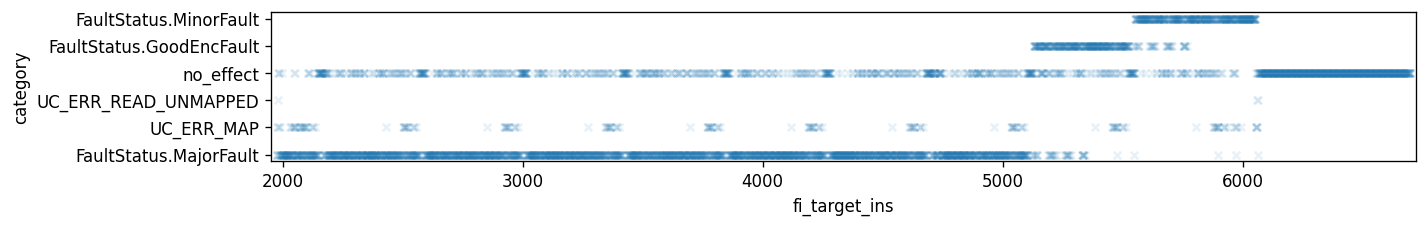

In [177]:
fig, ax = plt.subplots(1,1, figsize=(12,2), dpi=120, layout='tight')

df.plot.scatter('fi_target_ins', 'category', marker='x', alpha=.1, ax=ax)

ax.margins(5e-3,5e-2)

fig.savefig('dfa-plot-scatter.png')

(188, 6)


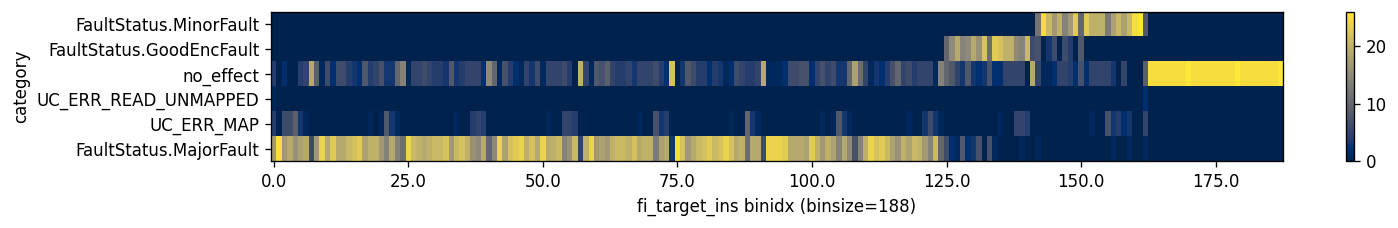

In [179]:
bins = (len(df['fi_target_ins'].unique())//25,len(df['category_num'].unique()))
print(bins)
H, xedges, yedges = np.histogram2d(df['fi_target_ins'], df['category_num'], bins=bins )

fig, ax = plt.subplots(1,1, figsize=(13,2), dpi=120, layout='tight')
handle = ax.imshow(H.T, aspect='auto',interpolation='nearest', origin='lower', cmap='cividis')#, vmax=4)#, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])

ax.set_yticks(list(category_mapping.values()), labels=category_mapping.keys())
xlims = ax.get_xlim()
ax.set_xticks(ax.get_xticks(), ax.get_xticks())
ax.set_xlim(xlims)

ax.set_ylabel('category')
ax.set_xlabel(f'fi_target_ins binidx (binsize={bins[0]})')
fig.colorbar(handle)

fig.savefig('dfa-plot-heat.png')

In [170]:
df[df['category']=='FaultStatus.GoodEncFault']['outbuf'].unique()

array(['9196ec73825b49ac6d5ae105f512a660',
       '5896ec73825b49566d5a4b05f5a2a660',
       '4d96ec73825b49d56d5a0605f5a6a660',
       'e896ec73825b49206d5ada05f5aea660',
       'cf96ec73825b49076d5a8705f5cea660',
       '5396ec73825b49626d5a5d05f503a660',
       'c796ec73825b498d6d5ac405f535a660',
       '0a96ec73825b495d6d5ab705f590a660',
       'f696ec73825b49616d5ae705f5c8a660',
       '3f96ec73825b496f6d5a6105f5fea660',
       '3896ec73825b49fc6d5af205f59aa660',
       'eb96ec73825b49486d5a1205f5e5a660',
       '7b96ec73825b49ae6d5af105f5ffa660',
       '5196ec73825b49336d5a9905f508a660',
       '0496ec73825b49606d5a7905f51ca660',
       '3396ec73825b499a6d5a2f05f569a660',
       '0196ecfd825b66a36d738a0574c9a660',
       '0196ec2b825b70a36dd18a052dc9a660',
       'd996ec73825b497f6d5adc05f51fa660',
       '0196ec20825b8ca36dec8a05fbc9a660',
       '0196ecdc825bd0a36d898a0585c9a660',
       '0196ece1825b6fa36d538a05a6c9a660',
       '0196ecd8825b77a36d988a05c8c9a660',
       '019

In [172]:
df[df['category']=='FaultStatus.MinorFault']['outbuf'].unique()

array(['b796ec73825b49a36d5a8a05f5c9a660',
       'e896ec73825b49a36d5a8a05f5c9a660',
       'ba96ec73825b49a36d5a8a05f5c9a660',
       'e096ec73825b49a36d5a8a05f5c9a660',
       '3896ec73825b49a36d5a8a05f5c9a660',
       '0596ec73825b49a36d5a8a05f5c9a660',
       'cb96ec73825b49a36d5a8a05f5c9a660',
       '6296ec73825b49a36d5a8a05f5c9a660',
       '5296ec73825b49a36d5a8a05f5c9a660',
       'bb96ec73825b49a36d5a8a05f5c9a660',
       'af96ec73825b49a36d5a8a05f5c9a660',
       '7196ec73825b49a36d5a8a05f5c9a660',
       '8b96ec73825b49a36d5a8a05f5c9a660',
       '3696ec73825b49a36d5a8a05f5c9a660',
       'c596ec73825b49a36d5a8a05f5c9a660',
       '0196ec73825b49a36d5a8a05f52ea660',
       '0196ec73825b49a36d5a8a05f5c8a660',
       '2896ec73825b49a36d5a8a05f5c9a660',
       '0196ec73825b49a36d5a8a05f5f5a660',
       '0196ec73825b49a36d5a8a05f5c0a660',
       '0196ec73825b49a36d5a8a05f539a660',
       '0196ec73825b49a36d5a8a05f58fa660',
       '0196ec73825b49a36d5a8a05f5eba660',
       '019